In [1]:
import numpy as np
import cv2 
import os

In [2]:
def grab_cut(img, mask=None, color_space_transform=cv2.COLOR_BGR2YUV):
    cv2.setRNGSeed(42)
    (h,w) = img.shape[:2] 
    bgdModel = np.zeros((1,13*5),np.float64) 
    fgdModel = np.zeros((1,13*5),np.float64) 
    tr_img = cv2.cvtColor(img, color_space_transform)
    
    mask = mask.copy()
    mask, _, _= cv2.grabCut(tr_img,mask,None,bgdModel,fgdModel,2,cv2.GC_INIT_WITH_MASK)

    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    
    # mask produced by grabCut may contain unwanted holes - close them here
    new_mask = np.zeros_like(mask)
    cv2.drawContours(new_mask, [cnt], 0, 255, thickness=cv2.FILLED)
    return new_mask

In [3]:
#convert rgba image to grab_cut compatible marker (initial mask)
def transform_marker(marker):
    marker_out = 2*np.ones((marker.shape[0], marker.shape[1])) # probable background
    marker_out[np.logical_and(marker[...,3] == 255, marker[...,2] == 255)] = 1 # true foreground
    marker_out[np.logical_and(marker[...,3] == 255, marker[...,2] == 0)] = 0 # true background
    return marker_out.astype(np.uint8)

In [4]:
bgr_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('imgs/'))]
markers = [transform_marker(cv2.imread(f'markers/{name}', cv2.IMREAD_UNCHANGED)) for name in sorted(os.listdir('markers/'))]
masks = [grab_cut(img, marker) for img, marker in zip(bgr_imgs, markers)]

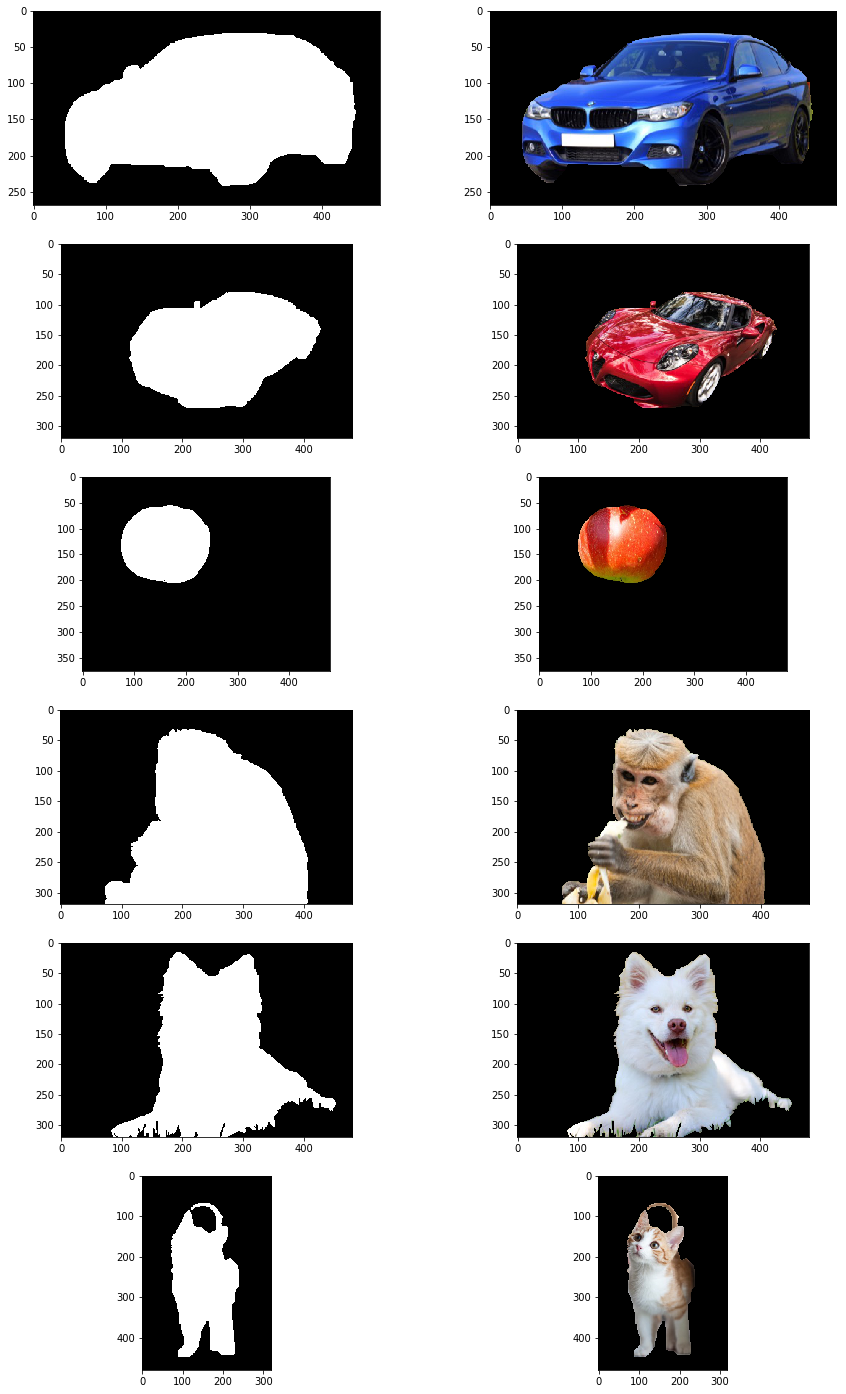

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,25))
for i, (mask, img) in enumerate(zip(masks, bgr_imgs)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(6,2,2*i+1)
    plt.imshow(mask, cmap='gray')
    plt.subplot(6,2,2*i+2)
    plt.imshow(cv2.bitwise_and(img, img, mask=mask))